# General Stuff

In [2]:
import os
from os.path import isfile, join
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch
from prettytable import PrettyTable

def readFiles():

	datasetpath =  f"../data/GroundTruth_Data/"
	embeddingspath = f"../data/newdataembedding/"

	files = [f for f in os.listdir(datasetpath) if (isfile(join(datasetpath, f)) and f.endswith('.csv'))]
	embeddingsFiles = [f for f in os.listdir(embeddingspath) if (isfile(join(embeddingspath, f)) and f.endswith('.pt'))]
	
	embeddings = torch.empty(0, device = 'cpu')
	for embeddingsFile in embeddingsFiles:
		embeddingsOffile = torch.load(embeddingspath+ embeddingsFile)
		embeddings = torch.concat([embeddings, embeddingsOffile])

	
	filesContent = {}
	content = []
	
	for file in files:
		try:
			df = pd.read_csv( datasetpath + file, encoding = "ISO-8859-1", on_bad_lines = "skip")
			filesContent[file] = df.columns.tolist()
			content += df.columns.tolist()
			for row in df.values:
				filesContent[file] += list(map(str,row))
				content += list(map(str,row))
		except Exception as e:
			print(f"Error in reading a csv file: file name: {file}, Error message: {e}")
		
	return filesContent, content, embeddings

def getMeXResults(X,top_results, filesContent, content):
	XResults = []
	i = 0
	cellsFileCombi = []
	for score, idx in zip(top_results[0], top_results[1]):
		if float("{:.4f}".format(score)) >= 0.3:
			for filename, val in filesContent.items():
				if content[idx] in val:
					if (filename, content[idx]) not in cellsFileCombi:
						cellsFileCombi.append((filename, content[idx]))
						XResults.append((filename, content[idx], score))
						i += 1
						if i == X:
							return XResults
	return XResults

def results(query, filesContent, content, embeddings):   
	
	symmetric_embedder = SentenceTransformer('all-mpnet-base-v2')
	results = {}
	
	query_embedding = symmetric_embedder.encode(query, convert_to_tensor = True)
	top_k = min(10, len(embeddings))
	cos_scores = util.cos_sim(query_embedding, embeddings)[0]
	top_results = torch.topk(cos_scores, len(embeddings), sorted = True)
	
	results = getMeXResults(top_k, top_results, filesContent, content)
	return results

def matching():
	filesContent, content, embeddings = readFiles()
	while True:
		query = "Rock Music"
		result = results(query, filesContent, content, embeddings)
		print("============================")
		print(f"your query is: {query}")
		
		table = [['Filename', 'Cell Value', 'Score']]
		for i in result:
			table.append([i[0], i[1], "{:.4f}".format(i[2])])
		tab = PrettyTable(table[0])
		tab.add_rows(table[1:])
		print(tab)
		
if __name__ == "__main__":
	matching()


FileNotFoundError: [Errno 2] No such file or directory: '../data/GroundTruth_Data/'

# Embeddings generation

In [3]:
import os
import torch
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util

In [4]:
model = SentenceTransformer("all-mpnet-base-v2")

In [5]:
def create_embeddings(table_name, base_path):

    if os.path.exists(base_path + table_name.replace('.csv', '.pt') ):
        return 'Embeddings file already exist'

    df = pd.read_csv(base_path + table_name)

    col_names = df.columns.tolist()
    df_columns = pd.DataFrame([col_names], columns=col_names)

    df = pd.concat([df_columns,df], ignore_index=True)
    df = df.map(lambda cell_value: str(cell_value))
    cell_values_flat = df.values.flatten()

    # Create embeddings for all cell values
    embeddings_list_flat = model.encode(cell_values_flat)

    # Save embeddings to pt file
    torch.save(embeddings_list_flat, base_path + table_name.replace('.csv', '.pt') )

    return 'Embeddings created successfully'

In [13]:
table_name = 'shopping_trends.csv'
base_path = 'semantic_matching/data/'

create_embeddings(table_name, base_path)

'Embeddings created successfully'

In [6]:
def create_data(table_name):

    print(f'Processing table: {table_name}')

    # Read csv data
    # base_path = 'semantic_matching/data/'
    df = pd.read_csv(table_name)

    # Add column names as first row
    col_names = df.columns.tolist()
    df_columns = pd.DataFrame([col_names], columns=col_names)
    df = pd.concat([df_columns,df], ignore_index=True)
    df = df.map(lambda cell_value: str(cell_value))
    cell_values_flat = df.values.flatten()

    # Create embeddings for all cell values
    # embeddings_list_flat = model.encode(cell_values_flat)
    embeddings_path = table_name.replace('.csv', '.pt')
    assert os.path.exists(embeddings_path), "Embeddings path doesn't exist"
    embeddings_list_flat = torch.load(embeddings_path)
    
    # cell_numbers_flat = list(range(len(cell_values_flat)))

    col_names_flat = col_names * int((len(cell_values_flat)/len(col_names)))

    # Final DataFrame
    name_and_embs = pd.DataFrame(list(zip([table_name.split('/')[-1]]*len(embeddings_list_flat), cell_values_flat , col_names_flat, embeddings_list_flat)), columns=['TableName','CellValue','CellValue_Column','Embeddings'])

    return name_and_embs


In [7]:
def get_top_k(query, input_df, k):

    query_emb = model.encode(query)
    cos_sims = util.cos_sim(query_emb, input_df['Embeddings']).numpy()[0]
    input_df['SimilaritiyScores'] = cos_sims
    input_df =  input_df.drop_duplicates(subset='CellValue').reset_index(drop=True)
    input_df =  input_df.sort_values('SimilaritiyScores', ascending=False)

    return input_df.iloc[:k]

In [8]:
def batch_semantic_matching(query, table_names, k):

    total_results_df = pd.DataFrame([],columns=['TableName','CellValue','CellValue_Column','Embeddings'])

    for table_name in table_names:

        # Calculate cosine similarities 
        res_df = create_data(table_name)
        total_results_df = pd.concat([total_results_df, res_df], ignore_index=True)

    # Get top-k similar results
    top_k_df = get_top_k(query, total_results_df, k).reset_index(drop=True)

    return top_k_df


In [9]:
# Get all csv files:
base_path = 'semantic_matching/data/'
csv_files = [base_path+file for file in os.listdir(base_path) if file.endswith('.csv')]
csv_files

['semantic_matching/data/alt_jobs.csv',
 'semantic_matching/data/shopping_trends.csv',
 'semantic_matching/data/healthcare_dataset.csv',
 'semantic_matching/data/jobs.csv',
 'semantic_matching/data/music.csv']

In [10]:
csv_files[0].split('/')[-1]

'alt_jobs.csv'

In [12]:
table_names = ['jobs.csv', 'shopping_trends.csv']

batch_semantic_matching('Fashion Data Analyst', csv_files, 5).to_json()

Processing table: semantic_matching/data/alt_jobs.csv


AssertionError: Embeddings path doesn't exist

# QDRANT

In [1]:
from qdrant_client import models
from qdrant_client import QdrantClient
from sentence_transformers import SentenceTransformer, util
import numpy as np
import pandas as pd
import os
import torch
from config import *

/Users/enaso/Library/CloudStorage/OneDrive-UniversiteitUtrecht/_GitHub/mira_gui/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Experiments

In [2]:
# model = SentenceTransformer("all-mpnet-base-v2")
model = SentenceTransformer(SBERT_PATH)
# model.save('sbertmodel')

In [3]:
client = QdrantClient(host="localhost", port=6333)

In [12]:
import os
import time
import json 
import shutil
import logging

import numpy as np
import pandas as pd
from pathlib import Path

from fastapi.staticfiles import StaticFiles
from fastapi.templating import Jinja2Templates
from fastapi.responses import FileResponse, JSONResponse, RedirectResponse
from fastapi import FastAPI, File, UploadFile, Response, HTTPException, Request

import qdrant_client
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import Distance, VectorParams

from pydantic import BaseModel

# from semantic_matching.code.config import *

import sentence_transformers
from sentence_transformers import SentenceTransformer, util
from semantic_matching.code.semantic_matching_tables import *

logging.basicConfig(level=logging.INFO)


def efficient_search(query):
    # Load table summaries JSON
    table_summaries_path = 'semantic_matching/table_summaries.json'
    with open(table_summaries_path, 'r') as f:
        table_summaries = json.load(f)

    # Perform clustering and search
    top_k_results = 10
    top_k_clusters = 20
    clustering_index_path = 'semantic_matching/merged_data/clustering_index.joblib'
    umap_trans_path = 'semantic_matching/merged_data/umap_trans.joblib'

    umap_trans = joblib.load(umap_trans_path)
    
    df_efficient = cluster_search(
        query, 
        top_k_results, 
        top_k_clusters, 
        clustering_index_path, 
        umap_trans, 
        client, 
        COLLECTION_NAME_CLUSTERED
    )

    # Merge results with table summaries
    formatted_results = []
    for _, row in df_efficient.iterrows():
        table_name = row['TableName'].replace('.csv', '')
        table_info = table_summaries[table_name]
        
        formatted_results.append({
            "TableName": table_name,
            "Rows": table_info['rows'],
            "Columns": table_info['columns'],
            "Type": table_info['dataset_type'],
            "CellValue": row['CellValue'],
            "CellValue_Column": row['CellValue_Column'],
            "SimilarityScores": row['SimilaritiyScores']
        })
    return df_efficient

In [13]:
df = efficient_search("Rock star")
print(df)

Batches: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]
INFO:httpx:HTTP Request: POST http://localhost:6333/collections/miraculous_clustered/points/search "HTTP/1.1 200 OK"


EFFICIENT SEARCH
   TableName            CellValue CellValue_Column  Cluster  SimilaritiyScores
0  music.csv                 Rock            Genre      199           0.682206
1  music.csv         Jimi Hendrix           Artist      236           0.474795
2  music.csv     The Fame Monster            Album      236           0.472210
3  music.csv                Queen           Artist      236           0.440522
4  music.csv            Bob Dylan           Artist      236           0.432364
5  music.csv  Queen & David Bowie           Artist      236           0.428086
6  music.csv          Billie Jean            Title      236           0.422697
7  music.csv               Artist           Artist      195           0.421042
8  music.csv              Madonna           Artist      236           0.417045
9  music.csv         Led Zeppelin           Artist      236           0.412368


In [64]:
from qdrant_client.http.models import Distance, VectorParams

client.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

True

In [12]:
print(COLLECTION_NAME_CLUSTERED)

miraculous_clustered


In [63]:
#client.delete_collection("miraculous")

In [49]:
table_name = 'semantic_matching/data/jobs.csv'
df = pd.read_csv(table_name)

In [ ]:
/Users/enaso/Library/CloudStorage/OneDrive-UniversiteitUtrecht/_GitHub/mira_gui/qdrant_storage

In [1]:
# Add column names as first row
col_names = df.columns.tolist()
df_columns = pd.DataFrame([col_names], columns=col_names)
df = pd.concat([df_columns,df], ignore_index=True)
# df = df.map(lambda cell_value: str(cell_value))
cell_values_flat = df.values.flatten()

# Create embeddings for all cell values
# embeddings_list_flat = model.encode(cell_values_flat)
embeddings_path = '/semantic_matching/embeddings'
print(embeddings_path)
assert os.path.exists(embeddings_path), "Embeddings path doesn't exist"
embeddings_list_flat = torch.load(embeddings_path)

# cell_numbers_flat = list(range(len(cell_values_flat)))

col_names_flat = col_names * int((len(cell_values_flat)/len(col_names)))

# Final DataFrame
name_and_embs = pd.DataFrame(list(zip([table_name.split('/')[-1]]*len(embeddings_list_flat), cell_values_flat , col_names_flat, embeddings_list_flat)), columns=['TableName','CellValue','CellValue_Column','Embeddings'])


NameError: name 'df' is not defined

In [23]:
name_and_embs =  name_and_embs.drop_duplicates(subset='CellValue').reset_index(drop=True)

NameError: name 'name_and_embs' is not defined

In [118]:
name_and_embs.head(10)

,TableName,CellValue,CellValue_Column,Embeddings
0,music.csv,Title,Title,"[0.0868767, 0.11400506, -0.0060333717, 0.05466..."
1,music.csv,Artist,Artist,"[0.020932574, 0.059109934, -0.012733743, 0.010..."
2,music.csv,Album,Album,"[0.021122865, 0.08372989, -0.008294431, -0.010..."
3,music.csv,Year,Year,"[0.002644233, 0.06685345, 0.015512964, -0.0041..."
4,music.csv,Genre,Genre,"[0.01897388, 0.04270177, 0.004695017, 0.009216..."
5,music.csv,Bohemian Rhapsody,Title,"[0.004845577, 0.043399297, -0.0050957813, -0.0..."
6,music.csv,Queen,Artist,"[0.0016129506, 0.007959083, -0.0048746886, -0...."
7,music.csv,A Night at the Opera,Album,"[0.0024867465, 0.052483708, -0.035862844, -0.0..."
8,music.csv,1975,Year,"[-0.01719815, 0.025505552, -0.0021372891, 0.02..."
9,music.csv,Rock,Genre,"[-0.027744388, 0.05039046, -0.008959857, 0.025..."


In [119]:
name_and_embs_dict = name_and_embs.to_dict('records')

In [138]:
# payload = map(lambda row: row[1].to_dict(), name_and_embs[['TableName','CellValue','CellValue_Column']].iterrows())

In [139]:
# client.upload_collection(
#     collection_name="miraculous",
#     vectors=name_and_embs['Embeddings'].values,
#     payload=payload,
#     ids=None,  # Vector ids will be assigned automatically
#     batch_size=256,  # How many vectors will be uploaded in a single request?
# )

In [28]:
import uuid

In [43]:
client.upload_records(
    collection_name=COLLECTION_NAME,
    records=[
        models.Record(
            id=str(uuid.uuid4()), vector=doc["Embeddings"].tolist(), payload={key: value for key, value in doc.items() if key != 'Embeddings'}
        )
        for idx, doc in enumerate(name_and_embs_dict)
    ],
)

NameError: name 'name_and_embs_dict' is not defined

In [121]:
hits = client.search(
    collection_name=COLLECTION_NAME,
    query_vector=model.encode("rock music").tolist(),
    limit=3,
)
for hit in hits:
    print(hit.payload, "score:", hit.score)

{'CellValue': 'Rock and Roll', 'CellValue_Column': 'Genre', 'TableName': 'music.csv'} score: 0.7538077
{'CellValue': 'Rock', 'CellValue_Column': 'Genre', 'TableName': 'music.csv'} score: 0.7436799
{'CellValue': 'Rock', 'CellValue_Column': 'Genre', 'TableName': 'music.csv'} score: 0.7436799


In [122]:
table_name = 'semantic_matching/data/music.csv'
df = pd.read_csv(table_name)

In [123]:
import socket

def is_port_open(host, port):
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.settimeout(1)  # Adjust the timeout as needed
    result = sock.connect_ex((host, port))
    sock.close()
    return result == 0

# Example: Check if Qdrant is running on port 8080 locally
host = "localhost"
port = 8080

if is_port_open(host, port):
    print(f"Port {port} is open. Qdrant is running.")
else:
    print(f"Port {port} is not open. Qdrant may not be running.")

Port 8080 is not open. Qdrant may not be running.


In [230]:
# df.to_dict('records')

In [231]:
from semantic_matching.code.semantic_matching_tables import add_to_collection, delete_collection, create_collection, count_table_occurencies

In [232]:
client = QdrantClient(host="localhost", port=6333)
qdrant_is_running = True

In [237]:
delete_collection(client , 'miraculous')

Deleting collection: miraculous


In [238]:
create_collection(client , 'miraculous')

Creating collection: miraculous


In [131]:
add_to_collection(UPLOAD_DIR+"jobs.csv", client, COLLECTION_NAME )

In [227]:
client = QdrantClient(host="localhost", port=6333)

In [24]:
filename = "jobs.csv"

In [25]:
result = client.count(
    collection_name=COLLECTION_NAME,
    count_filter=models.Filter(
        must=[
             models.FieldCondition(key="TableName", match=models.MatchValue(value=filename)),
        ]
    ),
    exact=True,
)

result.count

152

In [22]:
result.count

152

In [17]:
client.scroll(
    collection_name=COLLECTION_NAME,
    scroll_filter=models.Filter(
        must=[
            models.FieldCondition(key="TableName", match=models.MatchValue(value="jobs.csv")),
        ]
    ),
    # limit=1,
    with_payload=True,
    # with_vectors=False,
) 

([Record(id='035cd210-e1a7-4006-a058-ed455dcf5f6f', payload={'CellValue': '25-01-22', 'CellValue_Column': 'Date Posted', 'TableName': 'jobs.csv'}, vector=None),
  Record(id='036b76f4-abf7-44ec-a175-4e777fc07f11', payload={'CellValue': 'Quality Assurance Analyst', 'CellValue_Column': 'Job Name', 'TableName': 'jobs.csv'}, vector=None),
  Record(id='071f9ead-1948-4b25-9c9b-336b0f890085', payload={'CellValue': '05-05-22', 'CellValue_Column': 'Date Posted', 'TableName': 'jobs.csv'}, vector=None),
  Record(id='074b96cc-02b4-4517-83b0-957a91cf6a5a', payload={'CellValue': 115000, 'CellValue_Column': 'Salary', 'TableName': 'jobs.csv'}, vector=None),
  Record(id='0979312a-5a89-4f55-860f-77dafb30d39c', payload={'CellValue': 'Customer Success Specialist', 'CellValue_Column': 'Job Name', 'TableName': 'jobs.csv'}, vector=None),
  Record(id='0b69414a-91c9-4e0d-a1a9-96aa7e5b584c', payload={'CellValue': 95000, 'CellValue_Column': 'Salary', 'TableName': 'jobs.csv'}, vector=None),
  Record(id='0fa22209-9

# Efficient Search

## Prepair Umap

In [1]:
import os
from os.path import isfile, join
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm 
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import umap
import hdbscan
import sentence_transformers
from sentence_transformers import SentenceTransformer, util
import umap.plot
from umap.umap_ import nearest_neighbors
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client import QdrantClient, models
from semantic_matching.code.semantic_matching_utils import *
from semantic_matching.code.semantic_matching_tables import *

c:\Users\leandros\Documents\GitHub\mira_gui\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\leandros\Documents\GitHub\mira_gui\.venv\lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [92]:
def process_csv(csv_file, embeddings_path):
    print(f'Processing table: {csv_file}')

    # Read CSV data
    df = pd.read_csv(csv_file)

    # Load precomputed embeddings from file
    embeddings_list = torch.load(embeddings_path)

    # Add column names as the first row
    col_names = df.columns.tolist()
    df_columns = pd.DataFrame([col_names], columns=col_names)
    df = pd.concat([df_columns, df], ignore_index=True)
    df = df.map(lambda cell_value: str(cell_value))
    cell_values_flat = df.values.flatten()

    # Final DataFrame
    name_and_embs = pd.DataFrame(
        list(zip([csv_file.split('/')[-1]] * len(embeddings_list), cell_values_flat, col_names * len(embeddings_list), embeddings_list)),
        columns=['TableName', 'CellValue', 'CellValue_Column', 'Embeddings'])

    return name_and_embs

In [93]:
def create_data_and_save_embeddings(csv_directory, embeddings_directory):
    all_data_frames = []
    # all_embeddings = []

    # List all CSV files in the directory
    csv_files = [f for f in os.listdir(csv_directory) if f.endswith('.csv')]

    for csv_file in tqdm(csv_files, desc='Processing CSV files'):
        csv_path = os.path.join(csv_directory, csv_file)
        embeddings_path = os.path.join(embeddings_directory, f'{csv_file.split(".")[0]}.pt')

        df = process_csv(csv_path, embeddings_path)
        all_data_frames.append(df)
        # all_embeddings.extend(embeddings)

    # Concatenate data frames
    merged_df = pd.concat(all_data_frames, ignore_index=True)

    # Save the merged data frame to a CSV file (optional)
    # merged_df.to_csv('merged_data.csv', index=False)
    all_embeddings = merged_df['Embeddings']
    # Save the embeddings array to a single file
    torch.save(merged_df['Embeddings'].tolist(), embeddings_directory+'all_embeddings.pt')

    return merged_df, all_embeddings

In [111]:
# Create data and save embeddings
merged_df, all_embeddings = create_data_and_save_embeddings(BASE_DIR+DATA_DIR, BASE_DIR+EMBEDDINGS_DIR)

Processing CSV files: 100%|██████████| 6/6 [00:00<00:00, 30.15it/s]

Processing table: semantic_matching/data/jobs.csv
Processing table: semantic_matching/data/music.csv
Processing table: semantic_matching/data/music2.csv
Processing table: semantic_matching/data/music3.csv
Processing table: semantic_matching/data/music4.csv
Processing table: semantic_matching/data/shopping_trends.csv


Processing CSV files: 100%|██████████| 6/6 [00:00<00:00, 30.00it/s]


In [112]:
all_embeddings_array = np.vstack(all_embeddings)

In [113]:
knns_jobs = precompute_umap_knn(all_embeddings_array, 20, "euclidean", False, filename=BASE_DIR+JOBLIBS_DIR+"/allfiles_umap.joblib")

Computing k-NNs process finished. Runtime: 0.41s


c:\Users\leandros\Documents\GitHub\mira_gui\.venv\lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [114]:
umap_embeddings, umap_trans, _ = generate_umap_embeddings(20, 2, all_embeddings_array, pre_computed_knn=knns_jobs, n_jobs = -1)

UMAP finished. Runtime: 24.28s


In [ ]:
joblib.dump(umap_trans, "umap_transformer.joblib")
joblib.dump(umap_embeddings, "umap_embeddings.joblib")

c:\Users\leandros\Documents\GitHub\mira_gui\.venv\lib\site-packages\umap\plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

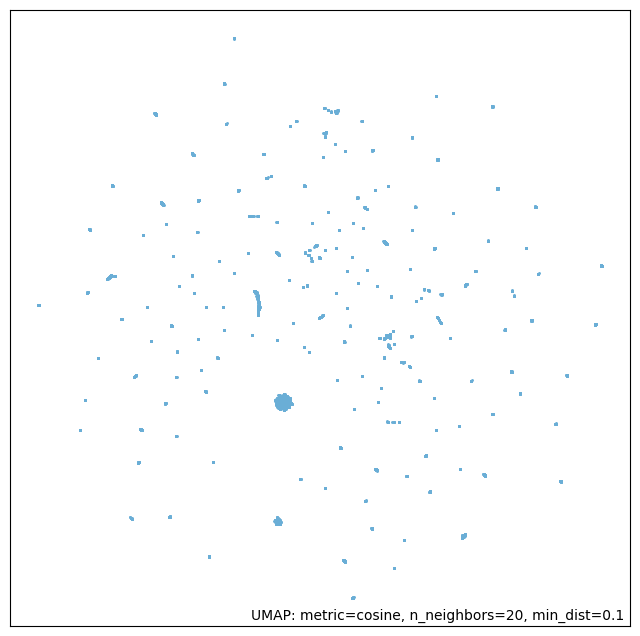

In [222]:
umap.plot.points(umap_trans)

## HDBSCAN

In [153]:
# Run the HDBSCAN function 
cluster_labels, clustering_index, cluster_medoids, runtime = hdbscan_clustering(umap_embeddings, 5)

HDBSCAN finished. Runtime: 0.18s


In [125]:
clustering_index.to_csv(BASE_DIR+'/merged_data/'+'clustering_index.csv', index=False)

In [117]:
merged_df['Cluster'] = cluster_labels
merged_df.drop('Embeddings', axis=1, inplace=True)
merged_df.to_csv(BASE_DIR+'/merged_data/datamerged_df_clustered.csv', index=False)

In [103]:
client = QdrantClient(host="localhost", port=6333)

In [123]:
delete_collection(client , COLLECTION_NAME_CLUSTERED)

Deleting collection: miraculous_clustered


In [124]:
create_collection(client , COLLECTION_NAME_CLUSTERED)

Creating collection: miraculous_clustered


In [120]:
merged_df.drop('Embeddings', axis=1, inplace=True)

In [110]:
# merged_df  = pd.read_csv(BASE_DIR+'/merged_data/datamerged_df_clustered.csv')

In [121]:
merged_df.to_csv(BASE_DIR+'/merged_data/datamerged_df_clustered.csv', index=False)

In [ ]:
# add_to_collection_clustered(BASE_DIR+'/merged_data/datamerged_df_clustered.csv', client, BASE_DIR+EMBEDDINGS_DIR+'all_embeddings.pt', COLLECTION_NAME_CLUSTERED)

In [126]:
table_name = BASE_DIR+'/merged_data/datamerged_df_clustered.csv'
embeddings_path = BASE_DIR+EMBEDDINGS_DIR+'all_embeddings.pt'

In [127]:
# print(f"QDRANT: Adding table {table_name} to {COLLECTION_NAME_CLUSTERED} collection")
assert os.path.exists(table_name), "Table path does not exist"
df = pd.read_csv(table_name)

# Load embeddings
# embeddings_path = table_name.replace('.csv', '.pt')
assert os.path.exists(embeddings_path), "Embeddings path doesn't exist"
embeddings_list_flat = torch.load(embeddings_path)

df['Embeddings'] = embeddings_list_flat

df_unduplicated = df.drop_duplicates(subset='CellValue').reset_index(drop=True)

df_records = df_unduplicated.to_dict('records')


# Add to collection

client.upload_records(
collection_name=COLLECTION_NAME_CLUSTERED,
records=[
    models.Record(
        id=str(uuid.uuid4()), vector=doc['Embeddings'].tolist(), payload={key: value for key, value in doc.items() if key!='Embeddings' }
    )
    for idx, doc in enumerate(df_records)
],
)


In [136]:
clustering_index = pd.read_csv(BASE_DIR+'/merged_data/'+'clustering_index.csv')

In [ ]:
query_text = "Data Scientist"
query_text_emb = model.encode(query_text)


In [143]:
query_text_emb_umap = umap_trans.transform([query_text_emb])

In [172]:
query_text_emb_umap[0].tolist()

[12.470820426940918, 1.0498449802398682]

In [ ]:
clustering_index['Medoid'].values.tolist()

In [175]:
similarities = util.cos_sim(query_text_emb_umap[0], clustering_index['Medoid'].values.tolist())

In [176]:
len(similarities.numpy()[0])

264

In [177]:
clustering_index['Similarity'] = similarities.numpy()[0]

In [180]:
clustering_index = clustering_index.sort_values('Similarity', ascending=False)

In [218]:
top_k_clusters = clustering_index.iloc[:5]

In [219]:
top_k_clusters = top_k_clusters['Cluster'].values.tolist()

In [220]:
top_k_clusters 

[146, 145, 4, 119, 200]

In [201]:
print("ANN SEARCH")
client = QdrantClient("localhost", port=6333)

hits = client.search(
    collection_name=COLLECTION_NAME_CLUSTERED,
    query_vector=model.encode("Data Scientist").tolist(),
    limit=QDRANT_TOP_K,
)

data = []

for hit in hits:
    payload_data = {
        'TableName': hit.payload.get('TableName', None),
        'CellValue': hit.payload.get('CellValue', None),
        'CellValue_Column': hit.payload.get('CellValue_Column', None),
        'Cluster': hit.payload.get('Cluster', None),
        'SimilaritiyScores': hit.score
    }
    data.append(payload_data)

df_ann = pd.DataFrame(data)

df_ann

ANN SEARCH


,TableName,CellValue,CellValue_Column,Cluster,SimilaritiyScores
0,jobs.csv,Data Scientist,Job Name,146,1.000000
1,jobs.csv,Data Analyst,Job Name,146,0.875535
2,jobs.csv,Research Scientist,Job Name,102,0.728945
3,jobs.csv,Researcher,Job Name,102,0.698688
4,jobs.csv,Software Developer,Job Name,145,0.690097
5,jobs.csv,Software Engineer,Job Name,-1,0.683607
6,jobs.csv,Systems Analyst,Job Name,146,0.680318
7,jobs.csv,Financial Analyst,Job Name,173,0.658135
8,jobs.csv,Web Developer,Job Name,145,0.593639
9,jobs.csv,Human Resources Specialist,Job Name,221,0.558448


In [221]:
print("EFFICIENT SEARCH")
client = QdrantClient("localhost", port=6333)

hits = client.search(
    collection_name=COLLECTION_NAME_CLUSTERED,
    query_vector=model.encode("Data Scientist").tolist(),
    query_filter=models.Filter(
    must=[models.FieldCondition(key="Cluster", match=models.MatchAny(any=top_k_clusters))]
    ),
    limit=QDRANT_TOP_K,
)

data = []

for hit in hits:
    payload_data = {
        'TableName': hit.payload.get('TableName', None),
        'CellValue': hit.payload.get('CellValue', None),
        'CellValue_Column': hit.payload.get('CellValue_Column', None),
        'Cluster': hit.payload.get('Cluster', None),
        'SimilaritiyScores': hit.score
    }
    data.append(payload_data)

df_efficient = pd.DataFrame(data)

df_efficient

EFFICIENT SEARCH


,TableName,CellValue,CellValue_Column,Cluster,SimilaritiyScores
0,jobs.csv,Data Scientist,Job Name,146,1.000000
1,jobs.csv,Data Analyst,Job Name,146,0.875535
2,jobs.csv,Software Developer,Job Name,145,0.690097
3,jobs.csv,Systems Analyst,Job Name,146,0.680318
4,jobs.csv,Web Developer,Job Name,145,0.593639
5,jobs.csv,IT Support Specialist,Job Name,146,0.558256
6,jobs.csv,DevOps Engineer,Job Name,145,0.537959
7,jobs.csv,Analytics,Business Capability,146,0.518827
8,jobs.csv,Quality Assurance Engineer,Job Name,146,0.444004
9,jobs.csv,System Administrator,Job Name,119,0.378990


In [205]:
df_ann

,TableName,CellValue,CellValue_Column,Cluster,SimilaritiyScores
0,jobs.csv,Data Scientist,Job Name,146,1.000000
1,jobs.csv,Data Analyst,Job Name,146,0.875535
2,jobs.csv,Research Scientist,Job Name,102,0.728945
3,jobs.csv,Researcher,Job Name,102,0.698688
4,jobs.csv,Software Developer,Job Name,145,0.690097
5,jobs.csv,Software Engineer,Job Name,-1,0.683607
6,jobs.csv,Systems Analyst,Job Name,146,0.680318
7,jobs.csv,Financial Analyst,Job Name,173,0.658135
8,jobs.csv,Web Developer,Job Name,145,0.593639
9,jobs.csv,Human Resources Specialist,Job Name,221,0.558448


In [27]:
count_embeddings_per_cluster(cluster_labels)

In [109]:
unique_embeddings, counts = np.unique(all_embeddings_array, axis=0, return_counts=True)

In [110]:
counts[counts>50]

array([ 65,  76,  61,  74,  77, 137,  55,  56,  51,  64, 127, 270, 897,
        99])

## Efficient Search - Pipeline

In [239]:
from semantic_matching.code.semantic_matching_tables import *

In [241]:
merged_df, all_embeddings = create_data_and_save_embeddings(BASE_DIR+DATA_DIR, BASE_DIR+EMBEDDINGS_DIR)

Processing CSV files:   0%|          | 0/3 [00:00<?, ?it/s]

Processing table: semantic_matching/data/jobs.csv
Processing table: semantic_matching/data/music.csv
Processing table: semantic_matching/data/shopping_trends.csv


Processing CSV files: 100%|██████████| 3/3 [00:00<00:00, 10.10it/s]


In [243]:
embeddings_array = np.vstack(all_embeddings)

In [244]:
knn = precompute_umap_knn(embeddings_array, 20, 'euclidean', save=False, filename="precomputed_knns.joblib")

Computing k-NNs process finished. Runtime: 0.46s


In [247]:
umap_embeddings, umap_trans, _ = generate_umap_embeddings(20, 2, embeddings_array, pre_computed_knn=knn, n_jobs = -1)

UMAP finished. Runtime: 20.57s


In [300]:
joblib.dump(umap_trans, BASE_DIR+'/merged_data/'+"umap_trans.joblib")

['semantic_matching/merged_data/umap_trans.joblib']

In [288]:
cluster_labels, clustering_index, cluster_medoids, runtime = hdbscan_clustering(umap_embeddings, 10)

HDBSCAN finished. Runtime: 0.2s


In [295]:
create_collection(client , COLLECTION_NAME_CLUSTERED)

Creating collection: miraculous_clustered


In [251]:
merged_df['Cluster'] = cluster_labels
merged_df.drop('Embeddings', axis=1, inplace=True)
merged_df.to_csv(BASE_DIR+'/merged_data/datamerged_df_clustered.csv', index=False)

In [297]:
add_to_collection_clustered(BASE_DIR+'/merged_data/datamerged_df_clustered.csv', client, BASE_DIR+EMBEDDINGS_DIR+'/all_embeddings.pt', COLLECTION_NAME_CLUSTERED)

QDRANT: Adding table semantic_matching/merged_data/datamerged_df_clustered.csv to miraculous_clustered collection


'Success'

In [290]:
clustering_index_path = BASE_DIR+'/merged_data/'+'clustering_index.joblib'
# clustering_index.to_csv(clustering_index_path, index=False)
# joblib.dump(clustering_index, filename=clustering_index_path)
clustering_index = joblib.load(clustering_index_path)

In [302]:
client.create_payload_index(
    collection_name=COLLECTION_NAME_CLUSTERED,
    field_name="Cluster",
    field_schema="integer",
)

UpdateResult(operation_id=36, status=<UpdateStatus.COMPLETED: 'completed'>)

In [303]:
df_efficient = cluster_search("Data Scientist", 10, 10,  clustering_index_path, umap_trans, client, COLLECTION_NAME_CLUSTERED)

EFFICIENT SEARCH


In [304]:
df_efficient 

,TableName,CellValue,CellValue_Column,Cluster,SimilaritiyScores
0,jobs.csv,Data Scientist,Job Name,139,1.000000
1,jobs.csv,Data Analyst,Job Name,139,0.875535
2,jobs.csv,Research Scientist,Job Name,134,0.728945
3,jobs.csv,Researcher,Job Name,134,0.698688
4,jobs.csv,Software Developer,Job Name,139,0.690097
5,jobs.csv,Software Engineer,Job Name,139,0.683607
6,jobs.csv,Systems Analyst,Job Name,139,0.680318
7,jobs.csv,Financial Analyst,Job Name,142,0.658135
8,jobs.csv,Web Developer,Job Name,139,0.593639
9,jobs.csv,IT Support Specialist,Job Name,139,0.558256


In [306]:
model = SentenceTransformer(SBERT_PATH)

In [340]:
sen1 = model.encode("Data Scientists")
sen2 = model.encode("Data Scientists: 69")
sen3 = model.encode("69 Data Scientist")

In [380]:
UPLOAD_DIR = "semantic_matching/data/"
os.listdir(UPLOAD_DIR)

['backup',
 'GroundTruth_Data',
 'jobs.csv',
 'music.csv',
 'newdataembedding',
 'shopping_trends.csv']

In [382]:
UPLOAD_DIR_sp = "/semantic_matching/data/"

str(round(os.path.getsize(UPLOAD_DIR+'jobs.csv') / 1024, 2))

'6.44'

# Table Embeddings

In [344]:
table1 = pd.read_csv("semantic_matching/data/"+'jobs.csv')

In [349]:
table1_str = table1.to_string(columns=table1.columns)
table1_str_emb = model.encode(table1_str)

In [373]:
sen1 = model.encode("Jobs and Salaries")

In [354]:
summary = "The provided table contains job listings with details such as job name, associated business capability, date posted, seniority level, and salary. The roles span various fields, including Information Technology (IT), Analytics, Management, Design, Marketing, Finance, Human Resources, Customer Service, Sales, Research, and Logistics. The positions range from Senior to Junior and Mid-Level roles, each associated with a specific salary. Notable roles include Software Engineer with a senior level in IT, a Data Analyst in Analytics, a Product Manager in Management, and a Customer Success Manager in Customer Service. The table offers a comprehensive overview of diverse job opportunities, each characterized by its unique specifications within different business capabilities."
summary_emb = model.encode(summary)

In [359]:
table_n_summary = table1_str + summary
table_n_summary_emb = model.encode(table_n_summary)

In [374]:
util.cos_sim(sen1, table1_str_emb)

tensor([[0.4855]])

In [375]:
util.cos_sim(sen1, summary_emb)

tensor([[0.5500]])

In [376]:
util.cos_sim(sen1, table_n_summary_emb)

tensor([[0.4855]])

In [362]:
table2 = """Job Name,Business Capability,Date Posted,Senior Level,Salary
Software Engineer,IT,15-02-22,Senior,120000
Data Analyst,Analytics,20-03-22,Junior,65000
Product Manager,Management,10-01-22,Senior,140000
Graphic Designer,Design,05-05-22,Junior,55000
Marketing Specialist,Marketing,30-04-22,Mid-Level,80000
Financial Analyst,Finance,28-02-22,Mid-Level,90000
Network Administrator,IT,15-06-22,Senior,110000
HR Coordinator,Human Resources,05-03-22,Junior,50000
Customer Support Representative,Customer Service,12-04-22,Junior,52000
Operations Manager,Management,25-01-22,Senior,130000
Sales Associate,Sales,20-05-22,Mid-Level,75000
Research Scientist,Research,10-02-22,Senior,115000
Web Developer,IT,08-03-22,Mid-Level,95000
Accountant,Finance,01-06-22,Mid-Level,85000
Technical Writer,Documentation,18-04-22,Junior,60000
Project Coordinator,Management,15-01-22,Junior,53000
Legal Assistant,Legal,10-05-22,Junior,54000
Customer Success Manager,Customer Service,20-02-22,Senior,125000
UX Designer,Design,25-03-22,Mid-Level,88000
Supply Chain Analyst,Logistics,10-06-22,Mid-Level,92000
Software Engineer,IT,15-02-22,Senior,120000
Data Analyst,Analytics,20-03-22,Junior,65000
Product Manager,Management,10-01-22,Senior,140000
Graphic Designer,Design,05-05-22,Junior,55000
Marketing Specialist,Marketing,30-04-22,Mid-Level,80000"""

table2_emb = model.encode(table2)

In [377]:
util.cos_sim(sen1, table2_emb)

tensor([[0.5561]])

# Viewing point